<a href="https://colab.research.google.com/github/Esteves4/IA-Proj/blob/main/IA_Proj_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset import

**API Install**

In [1]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



**Importing kaggle.json**

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


**Download dataset**

In [3]:
!kaggle datasets download -d lasaljaywardena/music-instrument-images-dataset

 38% 5.00M/13.0M [00:00<00:00, 48.0MB/s]
100% 13.0M/13.0M [00:00<00:00, 99.2MB/s]


In [4]:
!unzip -q music-instrument-images-dataset.zip

error:  cannot create music_instruments_images/music_instruments_images/1634109946175_├а┬╢┬Е├а┬╢┬Ь├а┬╢┬╜├а┬╖┬К 15 ├а┬╖┬Г├а┬╖┬Т├а┬╢┬В├а┬╢┬Ь├а┬╢┬╜├а┬╖┬К ├а┬╢┬з├а┬╖┬Ь├а┬╢┬┤├а┬╖┬К for sale.jpg
        File name too long
error:  cannot create music_instruments_images/music_instruments_images/1634110623389_Gramophone Disk ├а┬╖┬Г├а┬╖┬Т├а┬╢┬В├а┬╖┬Д├а┬╢┬╜ ├а┬╖┬Г├а┬╖┬Т├а┬╢┬В├а┬╢┬п├а┬╖┬Ф ├а┬╢┬н├а┬╖┬Р├а┬╢┬з├а┬╖┬Т for sale.jpg
        File name too long
error:  cannot create music_instruments_images/music_instruments_images/1634110697393_├а┬╖┬Г├а┬╖┬К├а┬╢┬з├а┬╖┬П├а┬╢┬╗├а┬╖┬К ├а┬╢┬й├а┬╖┬К├в┬А┬Н├а┬╢┬╗├а┬╢┬╕├а┬╖┬К ├а┬╖┬Г├а┬╖┬Щ├а┬╢┬з├а┬╖┬К for sale.jpg
        File name too long
error:  cannot create music_instruments_images/music_instruments_images/1634112242122_├а┬╢┬й├а┬╢┬╢├а┬╢┬╜├а┬╖┬К ├а┬╢┬Ъ├а┬╖┬У├а┬╢┬╢├а┬╖┬Э├а┬╢┬й├а┬╖┬К ├а┬╖┬Г├а┬╖┬К├а┬╢┬з├а┬╖┬С├а┬╢┬▒├а┬╖┬К├а┬╢┬й├а┬╖┬К for sale.jpg
        File name too long
error:  cannot create music_instruments_images/music_instruments_images/1634117799500_├а┬╢┬З├

In [6]:
import cv2
import pandas as pd 

basepath = "music_instruments_images/"
music_df = pd.read_csv("music_data_img.csv")

# Removing lines from csv where image were not unzipped or causing problems
drop_lines = []

# Getting images index with a reading problem
for index, row in music_df.iterrows():
  img = cv2.imread(basepath + row.Image_File)

  if img is None:
    drop_lines.append(index)

# Removing those images from the dataframe
for i in drop_lines:
  music_df.drop(i, inplace=True)

music_df.head()

,Label,Instrument_Type,Image_File
0,yamaha (sy-77) music synthesizer,Keyboard / Piano,music_instruments_images/1634109508851_Yamaha ...
1,srx-718 bass bin (pair),Studio / Live Music Equipment,music_instruments_images/1634109509147_SRX718 ...
2,piano (malcom mendis piano),Keyboard / Piano,music_instruments_images/1634109509344_Piano M...
3,yamaha semi acoustic guitars,String Instrument / Amplifier,music_instruments_images/1634109509573_Yamaha ...
4,yamaha guitar,String Instrument / Amplifier,music_instruments_images/1634109510073_Yamaha ...


**Data visualization**

In [7]:
import plotly.express as px

fig = px.histogram(music_df, x="Instrument_Type")
fig.show()


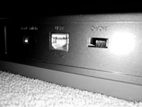
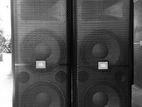
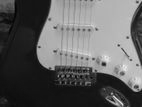
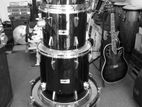
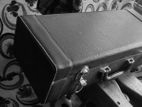
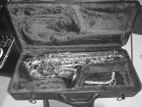
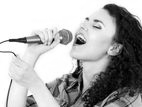
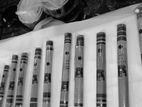

In [31]:
import cv2
from plotly.subplots import make_subplots

class_list = music_df.Instrument_Type.unique().tolist()

fig = make_subplots(rows=2, cols=4, subplot_titles=class_list)

for n,i in enumerate(class_list):
  temp = music_df[music_df.Instrument_Type == i].sample()
  img = cv2.imread(basepath + temp.Image_File.values[0])
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  fig.add_trace(px.imshow(img).data[0], row=int(n/4)+1, col=n%4+1)

fig.show()

**Importing images in Dataframe**

In [19]:
imgs = []

for index, row in music_df.iterrows():
  img = cv2.imread(basepath + row.Image_File)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  imgs.append(gray)

music_df["Image_Data"] = imgs

# Feature Extraction

In [9]:
def computeentropy(image):
  image = image.flatten()
  lensig=image.size
  symset=list(set(image.flatten()))
  numsym=len(symset)
  propab=[np.size(image[image==i])/(1.0*lensig) for i in symset]
  ent=np.sum([p*np.log2(1.0/p) for p in propab])
  return ent;

In [26]:
import cv2
import numpy as np
from scipy.stats import kurtosis, skew

var = []
mean = []
std = []
entropy = []
img_skew = []
img_kurtosis = []


for index, row in music_df.iterrows():
  img = row.Image_Data.flatten()

  var.append(round(np.var(img),2))
  mean.append(round(np.mean(img),2))
  std.append(round(np.std(img),2))
  entropy.append(round(computeentropy(img),2))
  img_skew.append(round(skew(img),2))
  img_kurtosis.append(round(kurtosis(img),2))
  


music_df["var"] = var
music_df["mean"] = mean
music_df["std"] = std
music_df["entropy"] = entropy
music_df["skew"] = img_skew
music_df["kurtosis"] = img_kurtosis

In [32]:
music_df["kurtosis"].head()

0   -0.23
1   -1.84
2    0.25
3    3.12
4   -1.17
Name: kurtosis, dtype: float64

# Pre-processing

**Fixing imbalaced dataset**

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

sampling_strategy = "not majority"
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_res, y_res = ros.fit_resample(X, y)
y_res.value_counts().plot.pie(autopct=autopct, ax=axs[1])
_ = axs[1].set_title("Over-sampling")

# Training

# Validation

# Test